Reference: 
https://www.tensorflow.org/tutorials/sequences/text_generation

https://www.tensorflow.org/beta/tutorials/text/text_generation#build_the_model

### Solution for text generation and classification

In [0]:
from __future__ import absolute_import, division, print_function
import os

import matplotlib.pyplot as plt

Install Tensorflow 

In [0]:
!pip install -q tensorflow-gpu==2.0.0-rc0
import tensorflow as tf

     |████████████████████████████████| 380.5MB 43kB/s 
     |████████████████████████████████| 4.3MB 41.7MB/s 
     |████████████████████████████████| 501kB 40.3MB/s 


## IMDB data
Let's load the IMDB movie review data. This is already preprocessed and is a part of `tf.keras.datasets` for your convenience. This data is encoded in `numpy` array, and we would need its dictionary to decipher it to plain text.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(
    path='imdb.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    seed=113,
    start_char=1,
    oov_char=2,
    index_from=3
)

17465344/17464789 [==============================] - 1s 0us/step


### Dictionary (tokens)
Let's also take advantage of the dictionary included in this dataset by reusing it.


In [0]:
word_index = tf.keras.datasets.imdb.get_word_index(path='imdb_word_index.json')

1646592/1641221 [==============================] - 0s 0us/step


In [0]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)

In [0]:
print(np.asarray((unique, counts)).T)

[[    0 12500]
 [    1 12500]]


The data contains 12,500 positive and negative reviews as indicated by label counts. Let's arbitrarily discard half of positive reviews. This renders our training data to be imbalanced for our purpose. We want to generate brand new reviews to make the training data balanced again. Our hypothesis is that brand new reviews can be used to augment imbalanced training data. 


In [0]:
idx = np.argwhere(y_train>0) # Select positive comment's index in training data
np.random.shuffle(idx) #Shuffle it at random

In [0]:
FRAC = 0.5
idxs = idx[:round(len(idx)*FRAC)] # Select random fraction FRAC
y_trains = y_train[idxs]
x_trains = x_train[idxs]

# preserve negative cases
idxn = np.argwhere(y_train==0)
x_train0 = x_train[idxn]
y_train0 = y_train[idxn]

In [0]:
len(idxs)

6250

In [0]:
word_index = tf.keras.datasets.imdb.get_word_index(path='imdb_word_index.json')

Let's append to the dictionary some extra tokens to handle padding for short reviews, as well as tagging start of a review and designate tokens to handle exceptions for unknown or unused words.

In [0]:
# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [0]:
letter_list = []
for word in list(word_index.keys()):
  for letter in word:
    if letter not in letter_list:
      letter_list.append(letter)
      

In [0]:
val = list(range(len(letter_list)+1)) 
letter_index = dict(zip(letter_list, val))

In [0]:
master_holder = [[]]

for record in x_trains:
  holder = []
  for idx in record[0]:
    if idx in reverse_word_index:
      holder.append(reverse_word_index[idx])
    else:
      holder.append('UNK')
  holder.pop(0) # remove <START>
  master_holder.append(holder)
master_holder.pop(0) # remove empty

[]

In [0]:
master_list=[]
master_list = [(' '.join(master_holder[idx])) for idx in range(len(master_holder))] # 1250 clear text as records in a list

In [0]:
len(master_list) 

6250

In [0]:
#Now ready to flatten all records into a long record string.
text = ' '.join(master_list)

In [0]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

94 unique characters


In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [0]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  ' ' :   0,
  "'" :   1,
  '0' :   2,
  '1' :   3,
  '2' :   4,
  '3' :   5,
  '4' :   6,
  '5' :   7,
  '6' :   8,
  '7' :   9,
  '8' :  10,
  '9' :  11,
  'a' :  12,
  'b' :  13,
  'c' :  14,
  'd' :  15,
  'e' :  16,
  'f' :  17,
  'g' :  18,
  'h' :  19,
  ...
}


In [0]:
# Show how the first 13 characters from the text are mapped to integers
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'actually this' ---- characters mapped to int ---- > [12 14 31 32 12 23 23 36  0 31 19 20 30]


In [0]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  print(idx2char[i.numpy()])

a
c
t
u
a


In [0]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

Let's print out a few reviews to make sure we mapped numpy array to plain text properly.

In [0]:

for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'actually this movie was not so bad it contains action comedy and excitement there are good actors in '
'this film for instance doug hutchison percy from the green mile who plays bristol another well known '
'actor is jamie kennedy from scream and three kings the main characters are played by jamie foxx as al'
'vin who was pretty good and also funny but the one who most surprised me was david morse as edgar cle'
'nteen he plays a different character than he usually does because in other films like the green mile '


## Input and target for text generation

Now we need to train a text generation model. The model requires training data and targets. Conceptually, text generation implies that given an input, the model generates an output, character by character. So we may create target as a one-position offset of the input. `split_input_target` function below accomplishes this.

In [0]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [0]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'actually this movie was not so bad it contains action comedy and excitement there are good actors in'
Target data: 'ctually this movie was not so bad it contains action comedy and excitement there are good actors in '


Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and tries to predict the index for "i" as the next character. At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.

In [0]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 12 ('a')
  expected output: 14 ('c')
Step    1
  input: 14 ('c')
  expected output: 31 ('t')
Step    2
  input: 31 ('t')
  expected output: 32 ('u')
Step    3
  input: 32 ('u')
  expected output: 12 ('a')
Step    4
  input: 12 ('a')
  expected output: 23 ('l')


Create training batches
We used tf.data to split the text into manageable sequences. But before feeding this data into the model, we need to shuffle the data and pack it into batches.

In [0]:
# Batch size 
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences, 
# so it doesn't attempt to shuffle the entire sequence in memory. Instead, 
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## Build The Model


Use `tf.keras.Sequential` to define the model. For this simple example three layers are used to define our model:

tf.keras.layers.Embedding: The input layer. A trainable lookup table that will map the numbers of each character to a vector with embedding_dim dimensions;
tf.keras.layers.GRU: A type of RNN with size units=rnn_units (You can also use a LSTM layer here.)
tf.keras.layers.Dense: The output layer, with vocab_size outputs.

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension 
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

Next define a function to build the model.

Use CuDNNGRU if running on GPU.

In [0]:
if tf.test.is_gpu_available():
  rnn = tf.keras.layers.GRU
else:
  import functools
  rnn = functools.partial(
    tf.keras.layers.GRU, recurrent_activation='sigmoid')

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    rnn(rnn_units,
        return_sequences=True, 
        recurrent_initializer='glorot_uniform',
        stateful=True),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [0]:
print(len(vocab), embedding_dim, BATCH_SIZE)

94 256 64


In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(len(vocab),embedding_dim, batch_input_shape=[BATCH_SIZE, None]),
  tf.keras.layers.GRU(units=rnn_units, 
                      return_sequences=True, 
                      recurrent_initializer='glorot_uniform', 
                      recurrent_activation='sigmoid', 
                      stateful=True),
  tf.keras.layers.Dense(len(vocab))         
])


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           24064     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 94)            96350     
Total params: 4,058,718
Trainable params: 4,058,718
Non-trainable params: 0
_________________________________________________________________


In [0]:
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 94) # (batch_size, sequence_length, vocab_size)


Next we need to define a loss function for the training. Then designate Adam optimizer for model compile.

### Attach an optimizer, and a loss function

The standard `tf.keras.losses.sparse_softmax_crossentropy` loss function works in this case because it is applied across the last dimension of the predictions. 

Because our model returns logits, we need to set the `from_logits` flag. 


In [0]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss  = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 94)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.5418663


In [0]:
model.compile(
    optimizer = tf.optimizers.Adam(),
    loss = loss)

### Configure checkpoints

Use a `tf.keras.callbacks.ModelCheckpoint` to ensure that checkpoints are saved during training:

In [0]:
import os
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Now we are ready for training a text generation model. Feel free to adjust training epochs.

In [0]:
EPOCHS=15

In [0]:
history=model.fit(dataset.repeat(), epochs=EPOCHS, steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback])

Train for 1266 steps
Epoch 1/6
1266/1266 [==============================] - 101s 80ms/step - loss: 1.6856
Epoch 2/6
1266/1266 [==============================] - 102s 80ms/step - loss: 1.3011
Epoch 3/6
1266/1266 [==============================] - 102s 80ms/step - loss: 1.2410
Epoch 4/6
1266/1266 [==============================] - 101s 80ms/step - loss: 1.2093
Epoch 5/6
1266/1266 [==============================] - 101s 80ms/step - loss: 1.1894
Epoch 6/6
1266/1266 [==============================] - 102s 80ms/step - loss: 1.1740


To get actual predictions from the model we need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

Note: It is important to sample from this distribution as taking the argmax of the distribution can easily get the model stuck in a loop.

Try it for the first example in the batch:

At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

Configure the training procedure using the `tf.keras.Model.compile` method. We'll use `tf.train.AdamOptimizer` with default arguments and the loss function. 

## Generate text

### Restore the latest checkpoint

To keep this prediction step simple, use a batch size of 1.

Because of the way the RNN state is passed from timestep to timestep, the model only accepts a fixed batch size once built.

To run the model with a different batch_size, we need to rebuild the model and restore the weights from the checkpoint.

In [0]:
tf.train.latest_checkpoint(checkpoint_dir)

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            24064     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 94)             96350     
Total params: 4,058,718
Trainable params: 4,058,718
Non-trainable params: 0
_________________________________________________________________


### The prediction loop

The following code block generates the text:

* It Starts by choosing a start string, initializing the RNN state and setting the number of characters to generate.

* Get the prediction distribution of the next character using the start string and the RNN state.

* Then, use a multinomial distribution to calculate the index of the predicted character. Use this predicted character as our next input to the model.

* The RNN state returned by the model is fed back into the model so that it now has more context, instead than only one word. After predicting the next word, the modified RNN states are again fed back into the model, which is how it learns as it gets more context from the previously predicted words.

Looking at the generated text, you'll see the model knows and imitates vocabulary. With the small number of training epochs, it has not yet learned to form coherent sentences.

## Generating Text
#### Starting seed 

In order to generate text, we need to supply the model a starting 'seed'. Lets Rank unique words in the IMDB texts by their frequency in descending order, and select top n words as our seeds. Each seed will allow the model to generate one string of text until the specified maximum length. 


In [0]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing) 
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a multinomial distribution to predict the word returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      
      # We pass the predicted word as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)
      
      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [0]:
generate_text(model, start_string=u"play ")

"play and protagonial reudden it'frusers prolo hamottez was funny and also funny funny br br for it is portrayed by any other cuttom could be that most reviews his louisianald give so high speed as ever taken to see it 7 wider and believable for this series becomes appeal to the stunning member of thab exteriorsheak of a perfect performance of time during the many times this is one first on the reversed aflitable producer jason stone arlant's fitting dread and called anansperson viking with venue as has been convincingly insignating in his curled glasse also the not sure that in him nolte is actually growing it thus irr natured at the u s to grace the group of people's bread of him gurnams with his powerful valet in one reason i don't think i sisperlays since the setting is that the response of the movie and get bodan an important alan nervous peril wroom winflown by dumberto along as that of a lout after the help on such time for cupider notes that for me because this film was shat it

In [0]:
text[:100]

'actually this movie was not so bad it contains action comedy and excitement there are good actors in'

In [0]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [0]:
word_by_frequency = word_count(text)

In [0]:
import operator
sorted_word = sorted(word_by_frequency.items(), reverse=True, key=lambda kv: kv[1])

I need to have 12500 positive samples. Since I only have half to start with, I need 6250 extra new positive samples to be generated by my model. I want to get top 6250 words from dictionary by frequency as the starting seed.

In [0]:
#n = len(idx) - len(x_trains) # the difference is the sample size I need to make up
n=int(12500/2)
from collections import Counter
d = Counter(text.split())
#d.most_common(n)

In [0]:
topn_start=[]
for k, v, in d.most_common(n):
  topn_start.append(k)

Lets examine one sample of generated positive review. See if it has the look or feels that resembles a real positive review

In [0]:
generate_text(model, start_string=topn_start[0])

"thernots are quiet mr kelly until he has a disible existence with bizarre producing obsession to the vennel is turn though while i even ear get into their own spoofs and creasy moving in law men with digicorp the dancing assures maybe character aconviously but that unfortunately you have primarily interesting the movie may not be the plots which had been one of them and it reminds me of complete second firm that explosions keeps you realized we're i got for any production this is the way o coming all them that deceitched and unpleasant a good hard for examplented into toniz with being shall trooper through gold actors who do because of the references while this is one of my mouth is very things are not impossible out of the depressing has the feet campbet that learns her and visited by later for all these years and just this film and a surprise episode with people the movie falls plot to an iving do i really have clearly interesting twists sets allowing the rest of trund in a style of

We are ready to generate new sentences, encode it to numpy array, merge with the original 1250 positive reviews.

In [0]:
generated = []
n=1
for start_word in topn_start:
  print(n)
  generated.append(generate_text(model, start_word))
  n+=1

In [0]:
type(generated)

Lets save this list for future use

In [0]:
import pickle
pickle_out = open("generated_201909.pickle","wb")
pickle.dump(generated, pickle_out)
pickle_out.close()

### Save generated text for convenience 
We may persist `generated` reviews as a `pickle` file to a cloud resource such as Google Cloud Platform (GCP) storage bucket. Steps below requires you to have an active GCP account. 

If you do not have a GCP account or simply wishes to continue using example `generated` reviews provided by the course author, please skip the steps below and go to the next section "Load generated positive reviews provided by author"

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

In [0]:
# Create the service client.
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')

from apiclient.http import MediaIoBaseDownload

In [0]:
project_id = 'project-2019'

In [0]:
with open('generated_201909.pickle', 'wb') as handle:
    pickle.dump(generated, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
fdir = './'
fname = 'generated_201909.pickle'
full_fname = fdir+fname
#write file to bucket
from googleapiclient.http import MediaFileUpload

media = MediaFileUpload(full_fname, 
                        mimetype='text/plain',
                        resumable=True)

request = gcs_service.objects().insert(bucket='<BUCKET_NAME>', 
                                       name=fname,
                                       media_body=media)

response = None
while response is None:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, response = request.next_chunk()

print('Upload complete')
print('https://console.cloud.google.com/storage/browser?project={}'.format(project_id))

### Load generated positive reviews provided by author

Lets set up authentication for accessing GCP bucket, where the generated positive reviews is stored by the author.

In [0]:
project_id = 'project-2019'
import uuid
bucket_name = '<BUCKET_NAME>' + str(uuid.uuid1())
from google.colab import auth
auth.authenticate_user()

In [0]:
!gsutil cp gs://<BUCKET_NAME>/generated_201909.pickle /tmp/generated_201909.pickle

Load generated positive reviews generated and provided by the author. It is a pickle file. 

The code cell below assumes the pickle file is put in /tmp directory relative to the current working directory. Your situation may vary. You may specify full file path if you wish.

In [0]:
import pickle
generated = pickle.load( open( "/tmp/generated_201909.pickle", "rb" ) )

Take a look at content 

In [0]:
generated[:5]

["then gangster and then this is so gore but the typical spipies a style i could be abrave you batman rick br br turn on behavior who ooughly see is the show replaced wat was film he did a very marie and his personalized in the fact that made on what that you could easily asto a true that this film care spy i saw this one film to court oscar the enjoy this movie is quite eventually a truly outstanding thumpter this movie will be monky little acting 70's who slowly pickford is braveheart i'm funk life hometo ho ill may a jobs who give died in u is ar alamo too the filmmakers in to be at least the stars or thought the sound in one sensitive character mile in this one is a scene way period and wouldn't born key flaw or the parts is stanwyck was dark as stephiger be the show else of the scale main and chooses and dark it's gaunthrous her shadow gold but i pinchular i e youngark where there were certain timogreat scenes are playing on worth these dudley order to reach the death this film wi

Lets now tokenize the generated reviews using `Punk`t tokenizer provided in the `NLTK` library.

In [0]:
x = np.empty((len(generated)), dtype=list)

In [0]:
import nltk
nltk.download('punkt')
i = 0
for _, merged_sentence in enumerate(generated):
  words = nltk.word_tokenize(''.join(merged_sentence))
  seqs = []
  for word in words:
    if word in word_index:
      seqs.append(word_index[word])
    else:
      seqs.append(word_index['<UNK>'])
      
  x[i] = seqs
  x[i] = [1] + x[i] # add <START> value in front.
  i += 1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
x

array([list([1, 95, 2112, 5, 95, 14, 9, 38, 599, 21, 4, 801, 2, 6, 405, 13, 100, 30, 2, 25, 1354, 4302, 10, 10, 471, 23, 2003, 37, 2, 67, 9, 4, 123, 2959, 29927, 16, 22, 29, 122, 6, 55, 2151, 5, 27, 35914, 11, 4, 192, 15, 93, 23, 51, 15, 25, 100, 714, 2, 6, 283, 15, 14, 22, 459, 2545, 13, 219, 14, 31, 22, 8, 2619, 735, 4, 358, 14, 20, 9, 179, 853, 6, 371, 1339, 2, 14, 20, 80, 30, 2, 117, 116, 4609, 3579, 37, 1364, 6423, 9, 5991, 13, 27038, 17754, 113, 2, 3821, 1815, 203, 6, 2632, 37, 202, 1131, 11, 1206, 9, 50156, 11104, 99, 4, 1057, 11, 8, 30, 33, 222, 4, 381, 42, 197, 4, 481, 11, 31, 2728, 109, 3693, 11, 14, 31, 9, 6, 136, 96, 810, 5, 62, 59139, 1447, 1317, 3279, 42, 4, 531, 9, 3334, 16, 465, 17, 2, 30, 4, 123, 334, 7, 4, 2407, 293, 5, 4880, 5, 465, 12, 3579, 2, 41, 2694, 1818, 21, 13, 2, 13, 963, 2, 121, 50, 71, 813, 2, 139, 26, 395, 23, 290, 134, 5934, 661, 8, 2101, 4, 341, 14, 22, 19, 6]),
       list([1, 67006, 31, 155, 15, 29, 9, 8, 30, 1055, 11, 200, 36, 26, 11, 2, 356, 27429, 

In [0]:
x_trains

array([[list([1, 165, 14, 20, 16, 24, 38, 78, 12, 1367, 206, 212, 5, 2318, 50, 26, 52, 156, 11, 14, 22, 18, 1825, 7517, 39973, 18746, 39, 4, 1419, 3693, 37, 299, 18063, 160, 73, 573, 284, 9, 3546, 4224, 39, 2039, 5, 289, 8822, 4, 293, 105, 26, 256, 34, 3546, 5788, 17, 6184, 37, 16, 184, 52, 5, 82, 163, 21, 4, 31, 37, 91, 770, 72, 16, 628, 8335, 17, 4500, 39520, 29, 299, 6, 275, 109, 74, 29, 633, 127, 88, 11, 85, 108, 40, 4, 1419, 3693, 1395, 5808, 4, 31025, 42, 4, 43737, 29, 299, 6, 55, 2259, 415, 5, 11, 7242, 4, 299, 220, 4, 1961, 6, 132, 209, 101, 1438, 63, 16, 327, 8, 67, 4, 64, 66, 1566, 155, 44, 14, 22, 26, 4, 450, 1268, 7, 4, 182, 3331, 2216, 63, 166, 14, 22, 382, 168, 6, 117, 1967, 444, 13, 197, 14, 16, 6, 184, 52, 117, 22])],
       [list([1, 4, 12475, 9, 6, 680, 22, 94, 293, 109, 5264, 256, 19, 35, 1732, 1493, 7, 1382, 5, 39453, 34, 3977, 9, 24, 129, 801, 632, 5264, 9, 6, 569, 132, 37, 9, 6606, 6, 522, 1696, 113, 18358, 260, 1084, 5284, 153, 11, 4, 5951, 7, 1043, 6448, 588, 29

We also need to create label for these generated text as positive review. Lets just use the training label already provided by the original data.

In [0]:
y_trains_generated = y_trains[:len(generated)]

Now we can put together original reviews with the generated reviews, and likewise their respective labels.

In [0]:
x_train_assembled = np.concatenate((x_train0, x_trains, x), axis = None)
y_train_assembled = np.concatenate((y_train0, y_trains, y_trains_generated), axis = None)


In [0]:
print(x_train_assembled.shape,y_train_assembled.shape )

(21875,) (21875,)


Take care of padding.

In [0]:
train_data = tf.keras.preprocessing.sequence.pad_sequences(x_train_assembled,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [0]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = len(word_index)

In [0]:
MAX_SENTENCE_LENGTH=256
EMBEDDING_SIZE=16
HIDDEN_LAYER_SIZE=64
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [0]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 64)          5669632   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               197632    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 5,883,777
Trainable params: 5,883,777
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Shuffle training data for cross validation during training cycle
FRAC = 0.8 # fraction of training data used for training. Remaining is for cross validation.
idx = np.arange(len(train_data))
np.random.shuffle(idx)

idxs = idx[:round(len(idx)*FRAC)] # Select random 80% for training data
partial_x_train = train_data[idxs]
partial_y_train = y_train_assembled[idxs]

x_val = np.delete(train_data, idxs.tolist(), axis=0) # select remaining as cross validation data
y_val = np.delete(y_train_assembled, idxs.tolist(), axis=0)


In [0]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 17500 samples, validate on 4375 samples
Epoch 1/40
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
17500/17500 [==============================] - 11s 655us/sample - loss: 0.5961 - acc: 0.6793 - val_loss: 0.3639 - val_acc: 0.8400
Epoch 2/40
17500/17500 [==============================] - 7s 428us/sample - loss: 0.2442 - acc: 0.9043 - val_loss: 0.2852 - val_acc: 0.8859
Epoch 3/40
17500/17500 [==============================] - 7s 427us/sample - loss: 0.0982 - acc: 0.9662 - val_loss: 0.3204 - val_acc: 0.9083
Epoch 4/40
17500/17500 [==============================] - 7s 427us/sample - loss: 0.0372 - acc: 0.9901 - val_loss: 0.3357 - val_acc: 0.8978
Epoch 5/40
17500/17500 [==============================] - 7s 428us/sample - loss: 0.0126 - acc: 0.9970 - val_loss: 0.3963 - val_acc: 0.8830
Epoch 6/40
17500/17500 [==============================] - 8s 429us/sample - loss: 0.0102 - acc: 0.9980 - val_loss: 0.4757 - val_acc: 0.8969
Epoch 7/40
17500

In [0]:
results = model.evaluate(test_data, y_test)

25000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

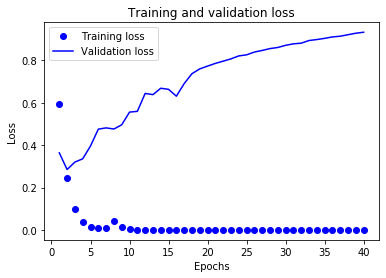

In [0]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

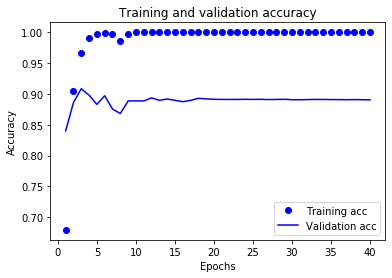

In [0]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
predicted = model.predict(test_data)

In [0]:
predicted[predicted > 0.5] = 1
predicted[predicted <= 0.5] = 0
predictedf = predicted.flatten().astype(int)

import pandas as pd
df3 = pd.DataFrame(data=predictedf, columns=['predicted'])
refdf = pd.DataFrame(data=y_test, columns=['actual'])

y_actu = pd.Series(refdf['actual'], name='ACTUAL')
y_pred = pd.Series(df3['predicted'], name='PREDICTED')
predicted_results = y_pred.tolist()
truth = y_actu.tolist()

dl_confusion = pd.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [0]:
dl_confusion

Predicted,0,1,All
Actual,,,
0,11332,1168,12500
1,3280,9220,12500
All,14612,10388,25000


In [0]:
 from sklearn.metrics import classification_report
report = classification_report(truth, predicted_results)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.91      0.84     12500
           1       0.89      0.74      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.83      0.82      0.82     25000
weighted avg       0.83      0.82      0.82     25000



Model produces reasonable precision and recall for positive reviews classification. This shows that machine text generation can produce realistic texts to make up for imbalance dataset.